In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

# Code focuses on 5 bright sources that are visible in both the VLA and Meerkat (MKT) data
# We do this to check if the observations from the Q and U channels match between these telescopes
# For this we have two methods. We can compare flux measurements from Meerkat with the fluxes that
# Erik measured with his flux measurement method and my method. In principle, we would expect these
# to be the same within error margins, since we both used aperture photometry on the same data.
# However, I will use the same physical aperture size on both Meerkat and VLA data where Erik might
# have used a different size. If this matches somewhat with Meerkat data, we can safely assume that
# the MKT data is not dominated by leakage or other systematic errors.

In [2]:
#We first import MKT datacubes in all channels (I,Q,U,V)
directory = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85'

I_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_header = I_hdu.header
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(directory + r'\Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)

I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

# We then define variables containing the subband frequencies
# Carefull: central frequencies in DR1 paper are wrong
freqs_lower = np.zeros(12)
freqs_middle = np.zeros(12)
freqs_upper = np.zeros(12)

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freqs_lower[n] = I_hdu.header['FREL'+number]
    freqs_middle[n] = I_hdu.header['FREQ'+number]
    freqs_upper[n] = I_hdu.header['FREH'+number]

In [3]:
# We calculate the linpol intensity cube and the freqmean and save the cube.
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto(directory + r'\Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

In [4]:
# We perform some preparatory work for flux measurements.
# First step is finding the sources.
# The background statistics are found using sigma clipping.
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

# We then define where we are going to look for, the criteria.
daofind = DAOStarFinder(fwhm=3.0, threshold=3.5*backgr_std)
mask = np.ones(linpol_intens_freqmean.shape, dtype=bool)
#These masks ensure we only select the five sources we want to compare with VLA
mask[1600:1700, 1250:1350] = False
mask[1100:1200, 1500:1600] = False
mask[1300:1500, 1200:1400] = False

# We then do the actual sourcefinding
sources_compar = daofind(linpol_intens_freqmean - backgr_median, mask=mask)
# And we prepare the apertures:
positions_compar = np.transpose((sources_compar['xcentroid'], sources_compar['ycentroid']))
apertures_compar = CircularAperture(positions_compar, r=7.)

for col in sources_compar.colnames:
    sources_compar[col].info.format = '%.8g'  # for consistent table output

# This also gives some flux results, but this doesn't take beamsize/pix into account
print(sources_compar)

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)
 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag    
--- --------- --------- ---------- ... --- ------------- --------- -----------
  1 1574.1474 1124.9486 0.39922598 ...   0 0.00090003421 9.9840803  -2.4982702
  2 1564.6967 1137.2616 0.40011825 ...   0 0.00017359151 1.9636412 -0.73265533
  3 1560.8153 1141.9812 0.39641346 ...   0 0.00036038106 3.8264251   -1.456983
  4  1356.121 1404.4902 0.39600383 ...   0 0.00010838422 1.1268673 -0.12968196
  5 1290.9782 1658.5458 0.39955294 ...   0  0.0015098529 16.715295  -3.0577851


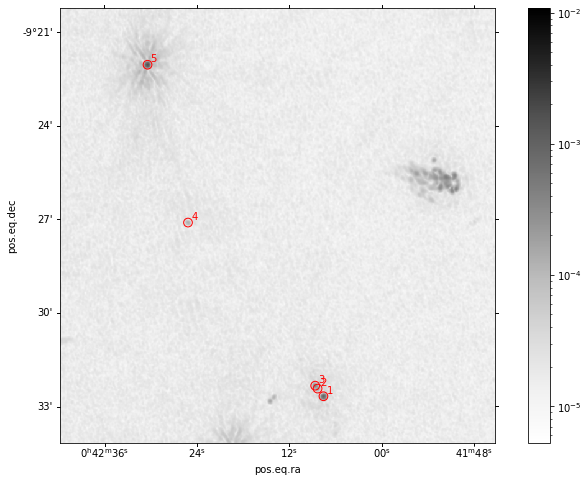

In [35]:
# We plot the selected sources with their apertures on the Meerkat data

plt.figure(figsize=(12,8))
plt.title('Apertures of selected sources plotted on linpol intensity')
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
plt.ylim(1050,1750)
plt.xlim(1150,1850)
apertures_compar.plot(color='red', lw=1)
for n in range(5):
    plt.text(sources_compar['xcentroid'][n]+5, sources_compar['ycentroid'][n]+5, sources_compar['id'][n], color='red')
plt.savefig('ACO85_Linpol_Freqmean_Aperscompar.pdf', dpi=300)

In [6]:
# We perform flux measurements:

#annulus_apertures_compar = CircularAnnulus(positions_compar, r_in=8., r_out=13.)
#apers_compar = [apertures_compar, annulus_apertures_compar]
FWHM_major_axis = 2.140979E-03*c.degree # Information from the header
FWHM_minor_axis = 1.972437E-03*c.degree
pixsize = 3.317774E-04*c.degree
print(FWHM_major_axis)

def photometry(data_local, apers_local, psize, min_ax, maj_ax):
    # This function calculates the flux from a source
    data_local_intensity = data_local*4*np.log(2)/(np.pi*maj_ax*min_ax)
    phot_table = aperture_photometry(data_local_intensity, apers_local)
    phot_mean = phot_table['aperture_sum']/apers_local.area
    flux = phot_mean*apers_local.area*(psize**2)
    phot_table['flux'] = flux
    return phot_table

phot_table_compar = photometry(linpol_intens_freqmean, apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
print(apertures_compar[0].area)
print(phot_table_compar)

3.7367132766055673e-05
153.93804002589985
 id      xcenter       ...    aperture_sum             flux         
           pix         ...                                          
--- ------------------ ... ------------------ ----------------------
  1 1574.1473878079303 ...  28431329.22645449  0.0009533349138974699
  2 1564.6966903277728 ... 11389089.851494972 0.00038188917959005675
  3  1560.815257203651 ... 14192657.428782342 0.00047589599979922556
  4 1356.1209625517888 ...  5168987.520831427 0.00017332205025869063
  5 1290.9782154774423 ...  46705818.85035536    0.00156609940525693


In [7]:
# Flux measurements are performed in all channels and saved in tables
I_phot_table_compar = np.zeros((12, len(sources_compar)))
Q_phot_table_compar = np.zeros((12, len(sources_compar)))
U_phot_table_compar = np.zeros((12, len(sources_compar)))
V_phot_table_compar = np.zeros((12, len(sources_compar)))

for n in range(12):
    I_slice_phot_compar = photometry(I_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    Q_slice_phot_compar = photometry(Q_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    U_slice_phot_compar = photometry(U_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    V_slice_phot_compar = photometry(V_cube[n], apertures_compar, pixsize, FWHM_minor_axis, FWHM_major_axis)
    for i in range(len(sources_compar)):
        I_phot_table_compar[n, i] = I_slice_phot_compar[i]['flux']
        Q_phot_table_compar[n, i] = Q_slice_phot_compar[i]['flux']
        U_phot_table_compar[n, i] = U_slice_phot_compar[i]['flux']
        V_phot_table_compar[n, i] = V_slice_phot_compar[i]['flux']

# The linear polarization intensity and angles are also calculated:
Pol_Angles_compar = 0.5*np.arctan(U_phot_table_compar/Q_phot_table_compar)
Linpol_compar = np.sqrt(U_phot_table_compar**2 + Q_phot_table_compar**2)

print(np.shape(I_phot_table_compar))

(12, 5)


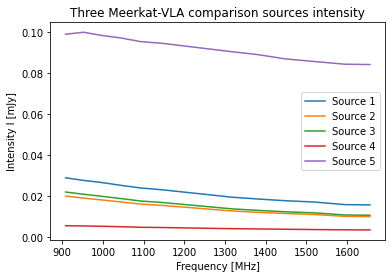

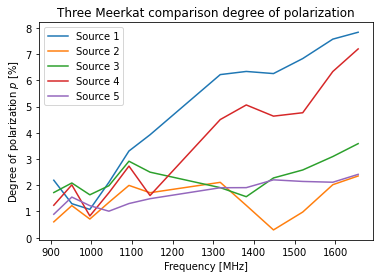

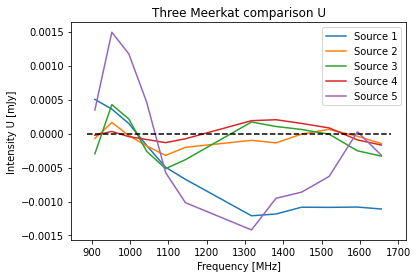

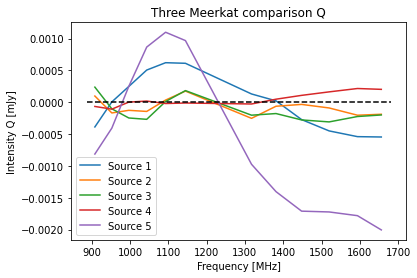

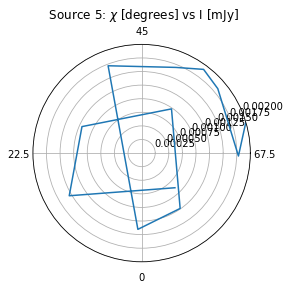

In [37]:
# The results from this photometry are plotted:
Labels = ['Source 1', 'Source 2', 'Source 3', 'Source 4', 'Source 5']

plt.title('Three Meerkat-VLA comparison sources intensity')
plt.plot(freqs_middle/1e6, I_phot_table_compar, label=Labels)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison degree of polarization')
plt.plot(freqs_middle/1e6, 100*Linpol_compar/I_phot_table_compar, label=Labels)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison U')
plt.plot(freqs_middle/1e6, U_phot_table_compar, label=Labels)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison Q')
plt.plot(freqs_middle/1e6, Q_phot_table_compar, label=Labels)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_compar[:,4], Linpol_compar[:,4])
ax.set_rmax(0.002)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 5: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [9]:
# Next, the flux measurements are loaded from VLA data by Erik, both the values and errors:
Freqs_VLA = np.loadtxt(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data\lambda_squared.txt', dtype=float)[:,1]*1e9

I_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
I_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))

fname_pt1 = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data\Abell_85_photometry\Stokes_'
fname_pt2 = r'\Stokes'
fname_pt3 = r'cor_source_'
fname_pt4 = r'_unc_source_'

for n in range(5):
    # We do 4-n because the number of the 5 sources in Eriks data is exactly opposite to ours
    I_phot_table_VLA[:,n] = np.load(fname_pt1+'I'+fname_pt2+'I'+fname_pt3+str(4-n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA[:,n] = np.load(fname_pt1+'Q'+fname_pt2+'Q'+fname_pt3+str(4-n)+'.npy', allow_pickle=True)
    U_phot_table_VLA[:,n] = np.load(fname_pt1+'U'+fname_pt2+'U'+fname_pt3+str(4-n)+'.npy', allow_pickle=True)
    I_phot_table_VLA_err[:,n] = np.load(fname_pt1+'I'+fname_pt2+'I'+fname_pt4+str(4-n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA_err[:,n] = np.load(fname_pt1+'Q'+fname_pt2+'Q'+fname_pt4+str(4-n)+'.npy', allow_pickle=True)
    U_phot_table_VLA_err[:,n] = np.load(fname_pt1+'U'+fname_pt2+'U'+fname_pt4+str(4-n)+'.npy', allow_pickle=True)

# The linear polarization intensity and angles are also calculated for VLA:
Pol_Angles_VLA = 0.5*np.arctan(U_phot_table_VLA/Q_phot_table_VLA)
Linpol_VLA = np.sqrt(U_phot_table_VLA**2 + Q_phot_table_VLA**2)

print(np.shape(I_phot_table_VLA))
print(np.shape(I_phot_table_VLA_err))

(90, 5)
(90, 5)


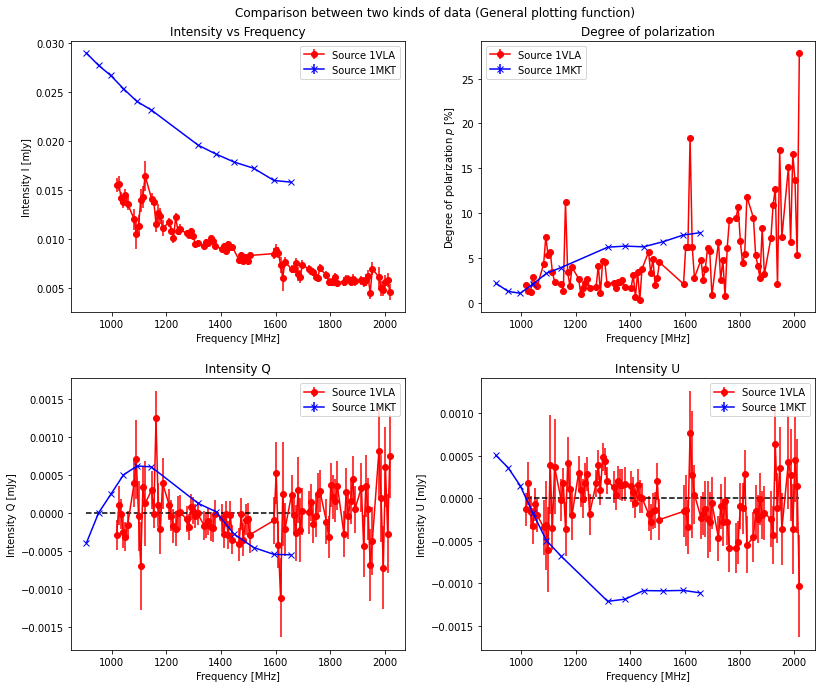

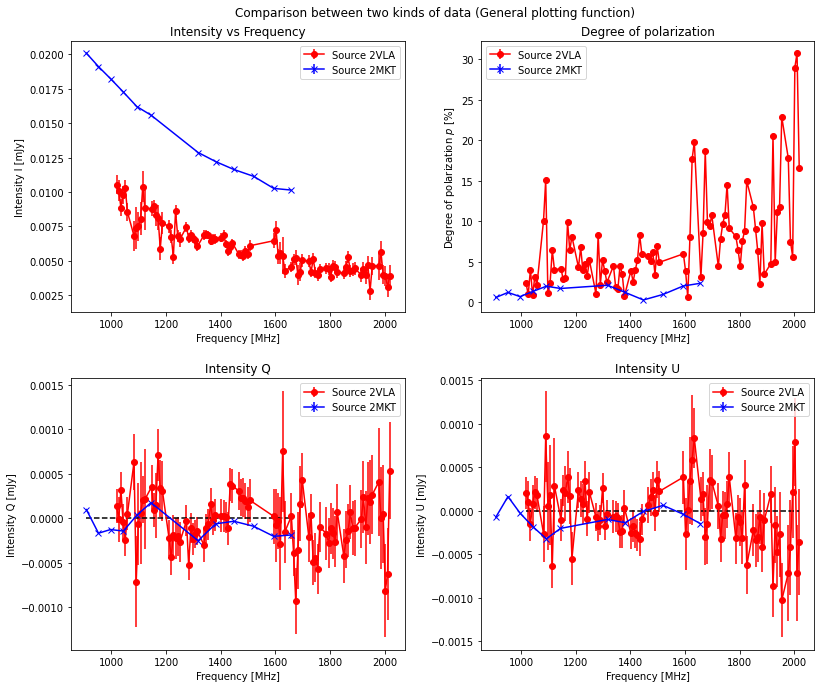

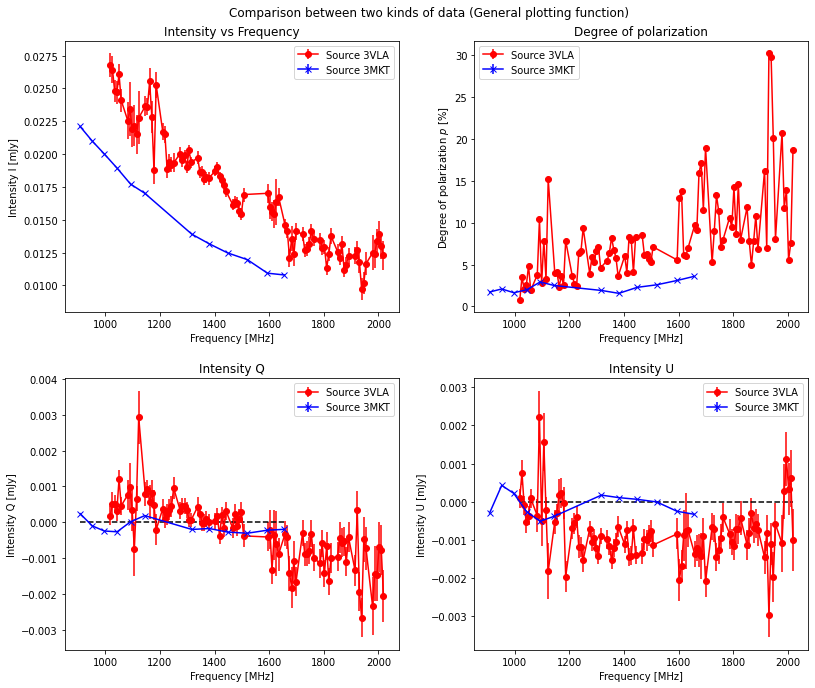

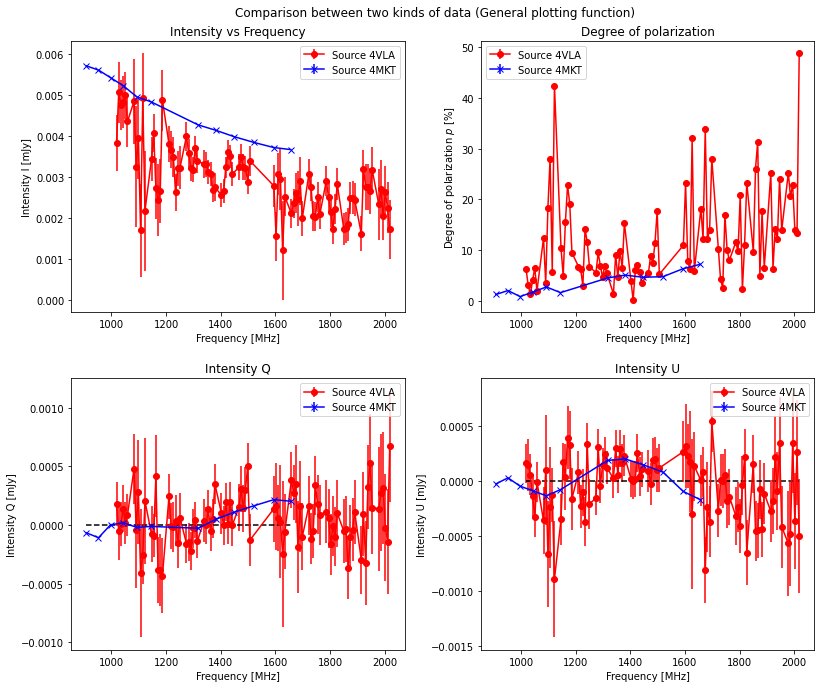

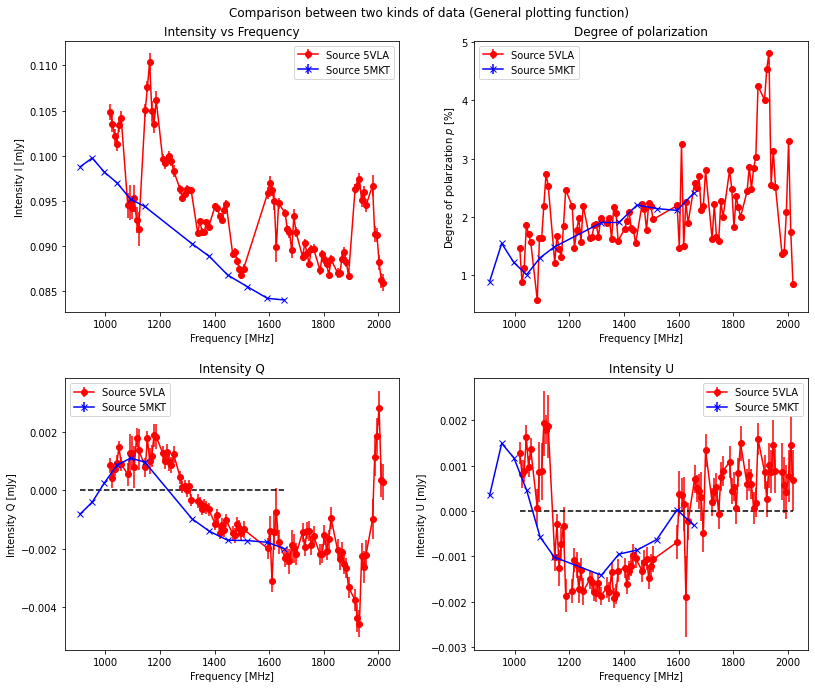

In [39]:
# The fluxmeasurements from Erik are plotted next to our own

# Because we will compare results regularly between MKT and VLA, let's define a function:
def plotter(freqs_1, freqs_2, I_1, I_2, I_1_err, I_2_err, Q_1, Q_2, Q_1_err, Q_2_err, U_1, U_2, U_1_err, U_2_err, Linpol_1, Linpol_1_err,Linpol_2, Linpol_2_err, Pol_Angles_1, Pol_Angles_2,  labels, name_1, name_2, channels, polar, angle, statistic):
    # This function takes all data from two sets of photometry data to be compared and plots both
    # Remove 4- everywhere by reversing array
    if channels:
        for n in range(len(sources_compar)):
            fig, axs = plt.subplots(2, 2)
            fig.set_size_inches(12, 10)
            fig.tight_layout(pad=4.5)

            fig.suptitle('Comparison between two kinds of data (General plotting function)')
            axs[0,0].errorbar(freqs_1/1e6, I_1[:,n], yerr=I_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[0,0].errorbar(freqs_2/1e6, I_2[:,n], yerr=I_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[0,0].set_title('Intensity vs Frequency')
            axs[0,0].set_xlabel('Frequency [MHz]')
            axs[0,0].set_ylabel('Intensity I [mJy]')
            axs[0,0].legend()

            axs[0,1].errorbar(freqs_1/1e6, 100*Linpol_1[:,n]/I_1[:,n], yerr=Linpol_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[0,1].errorbar(freqs_2/1e6, 100*Linpol_2[:,n]/I_2[:,n], yerr=Linpol_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[0,1].set_title('Degree of polarization')
            axs[0,1].set_xlabel('Frequency [MHz]')
            axs[0,1].set_ylabel('Degree of polarization $p$ [%]')
            axs[0,1].legend()

            axs[1,0].errorbar(freqs_1/1e6, Q_1[:,n], yerr=Q_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[1,0].errorbar(freqs_2/1e6, Q_2[:,n], yerr=Q_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[1,0].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
            axs[1,0].set_title('Intensity Q')
            axs[1,0].set_xlabel('Frequency [MHz]')
            axs[1,0].set_ylabel('Intensity Q [mJy]')
            axs[1,0].legend()

            axs[1,1].errorbar(freqs_1/1e6, U_1[:,n], yerr=U_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[1,1].errorbar(freqs_2/1e6, U_2[:,n], yerr=U_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[1,1].hlines(0, min(freqs_1)/1e6, max(freqs_1)/1e6, color='black', linestyle='dashed')
            axs[1,1].set_title('Intensity U')
            axs[1,1].set_xlabel('Frequency [MHz]')
            axs[1,1].set_ylabel('Intensity U [mJy]')
            axs[1,1].legend()

            plt.show()

    if polar:
        for n in range(len(sources_compar)):
            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
            fig.set_size_inches(8, 8)
            ax.plot(4*Pol_Angles_1[:,n], I_1[:,n],color='red', marker='o', label=labels[n] + name_1)
            ax.plot(4*Pol_Angles_2[:,n], I_2[:,n],color='blue', marker='x', label=labels[n] + name_2)
        #    ax.set_rmax(1.1*np.max(I_hist_VLA[:,n]))
            ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
            ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
            ax.grid(True)
            ax.set_title(r" Source "+str(n+1)+r": $\chi$ [degrees] vs I [mJy]")
            ax.legend()
            plt.show()

    if angle:
        for n in range(len(sources_compar)):
            plt.figure(figsize=(8,6))
            plt.plot(freqs_1/1e6, Pol_Angles_1[:,n], color='red', marker='o', label=labels[n] + name_1)
            plt.plot(freqs_2/1e6, Pol_Angles_2[:,n], color='blue', marker='x', label=labels[n] + name_2)
            plt.xlabel('Frequency [MHz]')
            plt.ylabel('Angle [Deg]')
            plt.title(r" Source "+str(n+1)+r' Angle vs frequency VLA and MKT comparison (red=VLA, blue=MKT)')
            plt.legend()
            plt.show()

    if statistic:
        colors=['red','orange','green','blue','purple']
        for n in range(5):
            plt.scatter(I_1[:,n], I_2[:,n], color=colors[n])
        plt.title('Correlation I intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(name_1+'I [mJy]')
        plt.ylabel(name_2+'I [mJy]')
        plt.show()
        for n in range(5):
            plt.scatter(Q_1[:,n], Q_2[:,n], color=colors[n])
        plt.title('Correlation Q intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(name_1+'Q [mJy]')
        plt.ylabel(name_2+'Q [mJy]')
        plt.show()
        for n in range(5):
            plt.scatter(U_1[:,n], U_2[:,n], color=colors[n])
        plt.title('Correlation U intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(name_1+'U [mJy]')
        plt.ylabel(name_2+'U [mJy]')
        plt.show()

# We trigger the plotter function:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_phot_table_compar, I_phot_table_VLA_err, np.zeros(np.shape(I_phot_table_compar)), Q_phot_table_VLA, Q_phot_table_compar, Q_phot_table_VLA_err, np.zeros(np.shape(Q_phot_table_compar)), U_phot_table_VLA, U_phot_table_compar, U_phot_table_VLA_err, np.zeros(np.shape(U_phot_table_compar)), Linpol_VLA, np.zeros(np.shape(Linpol_VLA)), Linpol_compar, np.zeros(np.shape(Linpol_compar)), Pol_Angles_VLA, Pol_Angles_compar, Labels, name_1='VLA', name_2='MKT', channels=True, polar=False, angle=False, statistic=False)

In [18]:
# In order to evaluate the data from Meerkat and the VLA at the same frequencies in the same subbands
# we can bin the data according to the subbands from MKT. This is possible because the VLA has much more
# frequency planes (90) and thus each bin will contain enough VLA planes

# We first define the bin edges. We do this in two parts because the MKT data has a hole in the freqs due to interference
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

# We prepare arrays to be filled with binned data:
I_hist_VLA, Q_hist_VLA, U_hist_VLA = np.zeros((12,5)), np.zeros((12,5)), np.zeros((12,5))
I_hist_VLA_err, Q_hist_VLA_err, U_hist_VLA_err = np.zeros((12,5)), np.zeros((12,5)), np.zeros((12,5))

def binner(freqs, phot, stat):
    # This binner works in two seperate steps because our Meerkat data has a hole in the freqs
    hist_1,_,_ = stats.binned_statistic(freqs, phot, statistic=stat, bins=bins_VLA_1)
    hist_2,_,_ = stats.binned_statistic(freqs, phot, statistic=stat, bins=bins_VLA_2)
    return np.append(hist_1, hist_2)

# Binning is performed for all 5 sources:
for n in range(5):
    I_hist_VLA[:,n] = binner(Freqs_VLA, I_phot_table_VLA[:,n], 'mean')
    I_hist_VLA_err[:,n] = binner(Freqs_VLA, I_phot_table_VLA[:,n], 'std')

    Q_hist_VLA[:,n] = binner(Freqs_VLA, Q_phot_table_VLA[:,n], 'mean')
    Q_hist_VLA_err[:,n] = binner(Freqs_VLA, Q_phot_table_VLA[:,n], 'std')

    U_hist_VLA[:,n] = binner(Freqs_VLA, U_phot_table_VLA[:,n], 'mean')
    U_hist_VLA_err[:,n] = binner(Freqs_VLA, U_phot_table_VLA[:,n], 'std')

# We also calculate the linpol intensity and angles
Pol_Angles_VLA_hist = 0.5*np.arctan(U_hist_VLA/Q_hist_VLA)
Linpol_VLA_hist = np.sqrt(U_hist_VLA**2 + Q_hist_VLA**2)
Linpol_VLA_hist_err = (U_hist_VLA*U_hist_VLA_err + Q_hist_VLA*Q_hist_VLA_err)/Linpol_VLA_hist

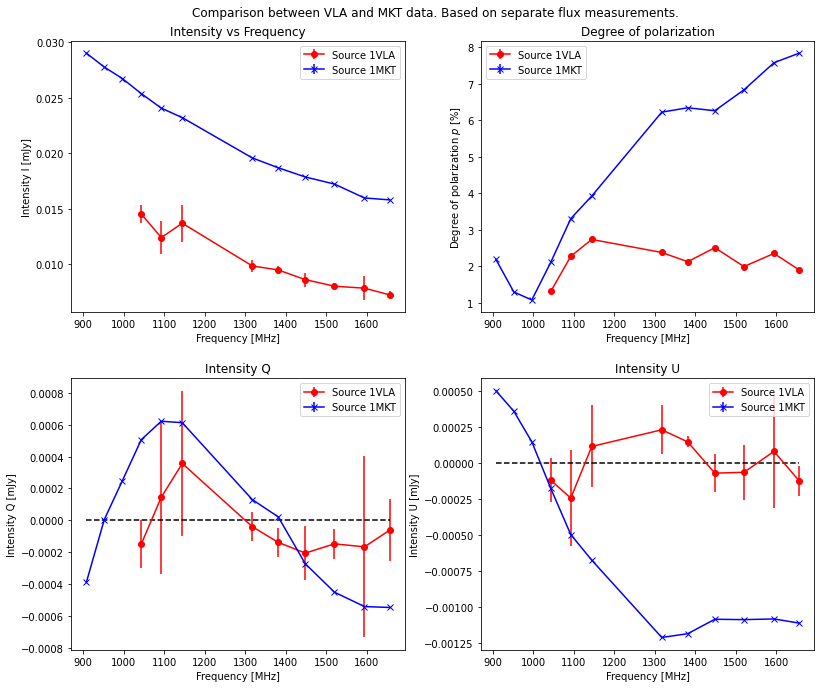

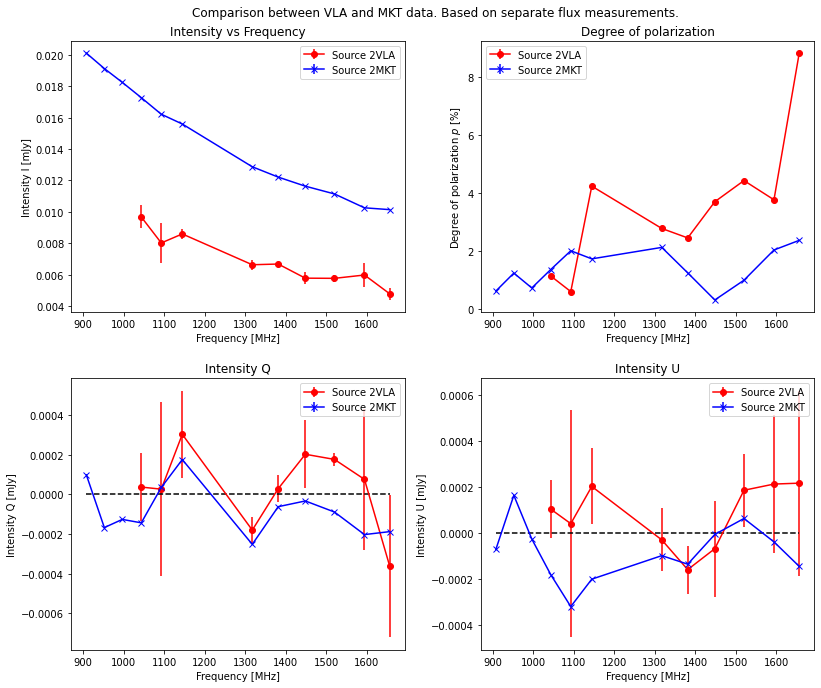

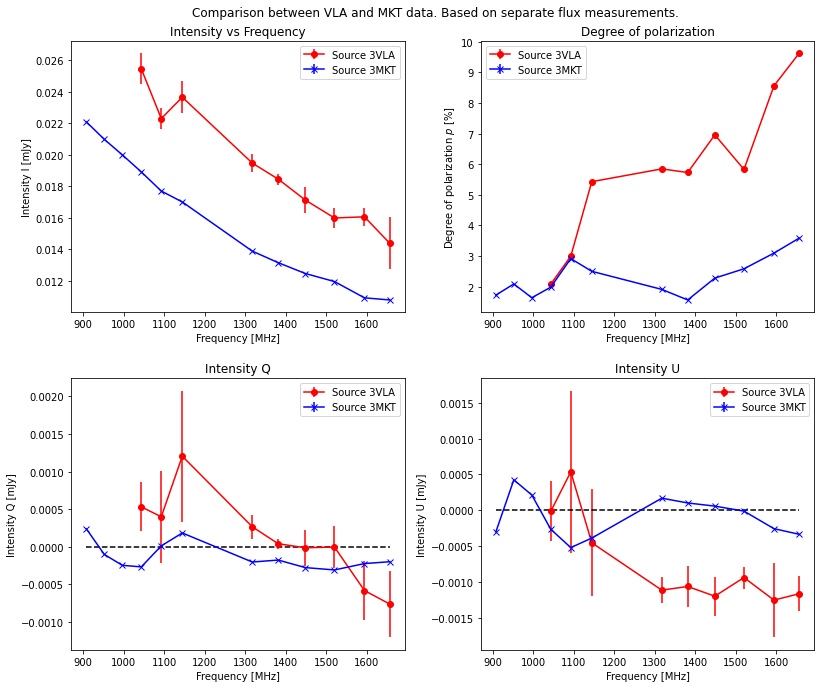

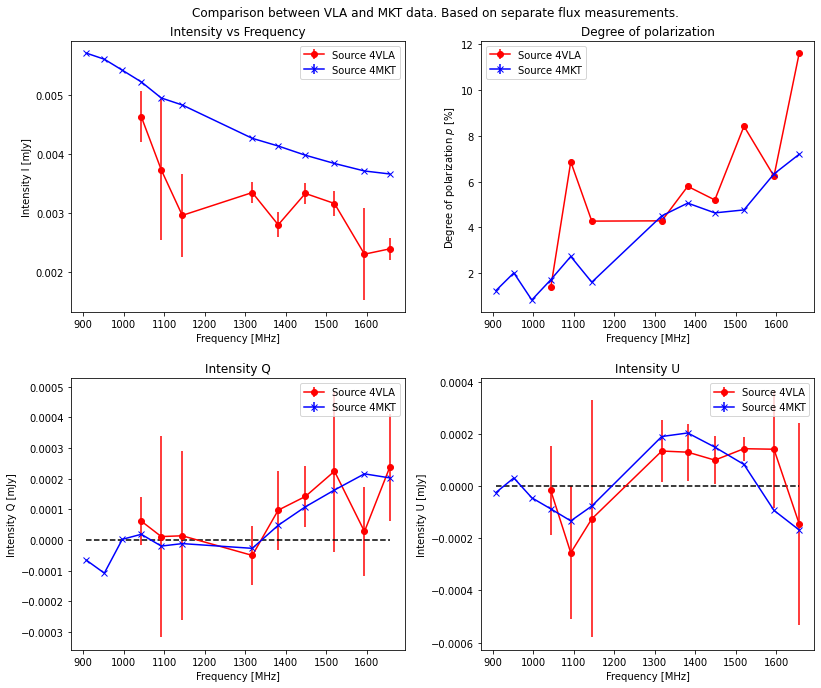

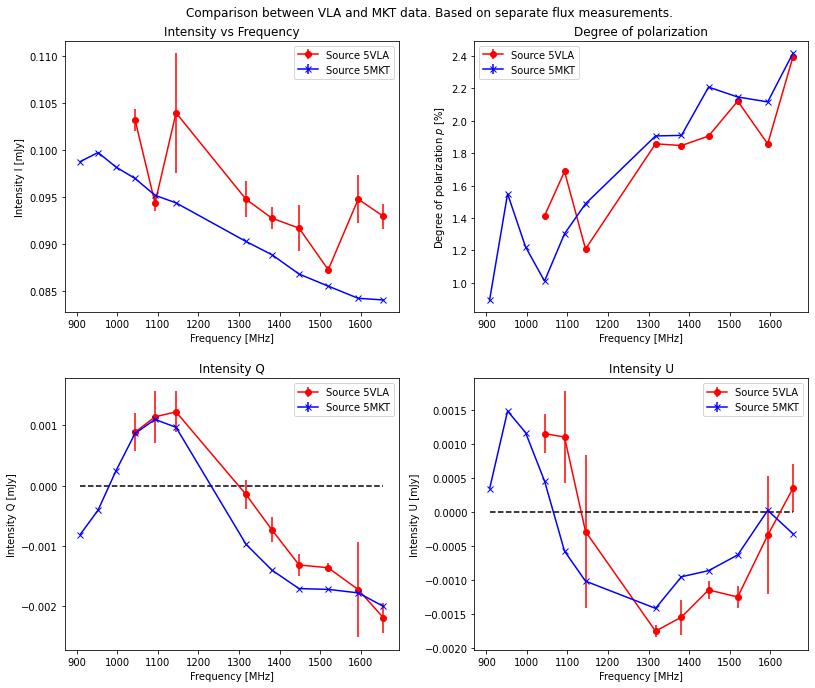

In [20]:
# We plot the results from the binning of Eriks flux measurements
plotter(freqs_middle, freqs_middle, I_hist_VLA, I_phot_table_compar, I_hist_VLA_err, np.zeros(np.shape(I_phot_table_compar)), Q_hist_VLA, Q_phot_table_compar, Q_hist_VLA_err, np.zeros(np.shape(Q_phot_table_compar)), U_hist_VLA, U_phot_table_compar, U_hist_VLA_err, np.zeros(np.shape(U_phot_table_compar)), Linpol_VLA_hist, np.zeros(np.shape(Linpol_VLA_hist)), Linpol_compar, np.zeros(np.shape(Linpol_compar)), Pol_Angles_VLA_hist, Pol_Angles_compar, Labels, name_1='VLA', name_2='MKT', channels=True, polar=False, angle=False, statistic=False)

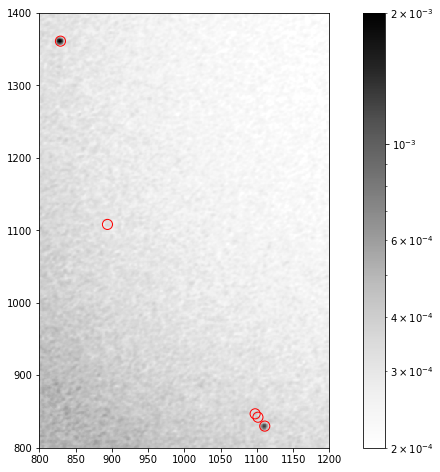

In [26]:
# Next step is to try to measure the flux in the VLA data ourselves
dir_VLA = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data'
fname_pt2 = r'-image.pbcor.smoothed.fits'

# We get lots of useless warnings useless accoring to internet, so we turn this off (warning type: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57066.880035 from DATE-OBS'. [astropy.wcs.wcs] WARNING: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to -107.618000 from OBSGEO-[XYZ]. Set OBSGEO-B to 34.078827 from OBSGEO-[XYZ]. Set OBSGEO-H to 2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs])
import warnings
warnings.filterwarnings("ignore")

# We used a seperate notebook to make a freqmean linpol image of VLA data,
# which is usefull to see if our apertures match the data from VLA.
# This is because it is always possible that the VLA or Meerkat has significant pointing errors
Fits_Linpol_VLA_hdu = fits.open(get_pkg_data_filename(dir_VLA + r'\Abell_85_VLA_Linpol_Freqmean.fits'))
Fits_Linpol_VLA = Fits_Linpol_VLA_hdu[0].data.squeeze()

# Prepare for apers and flux measurement:
pixsize_VLA = 3.333333333333E-04*c.degree # All taken from header
FWHM_major_axis_VLA = 2.327777777795E-03*c.degree
FWHM_minor_axis_VLA = 2.327777776737E-03*c.degree
Aperturesize_VLA = 7*pixsize/pixsize_VLA
plot_VLA_apers = True

Q_phot_table_VLA_own = np.zeros((90, len(sources_compar)))
U_phot_table_VLA_own = np.zeros((90, len(sources_compar)))

# We measure the flux for each frequency and save it:
for n in range(90):
    # Fits images are loaded
    fname_pt1 = r'G115.16-72.09_'+(4-len(str(n)))*'0'+str(n)

    Q_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '\stokes_q\\' + fname_pt1+r'-Q'+fname_pt2))
    Q_plane = Q_hdu[0].data.squeeze() # drops the size-1 axes
    Q_header = Q_hdu[0].header
    Q_wcs_VLA = wcs.WCS(Q_header).celestial
    Q_new_header = Q_wcs_VLA.to_header()

    U_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '\stokes_u\\' + fname_pt1+r'-U'+fname_pt2))
    U_plane = U_hdu[0].data.squeeze() # drops the size-1 axes
    U_header = U_hdu[0].header
    U_wcs_VLA = wcs.WCS(U_header).celestial
    U_new_header = U_wcs_VLA.to_header()

    if n == 0:
        # To select same regions in VLA, we need to convert pixel coords between MKT and VLA
        I_wcs_new = wcs.WCS(I_header).celestial
        positions_VLA = np.zeros(np.shape(positions_compar))

        for i in range(len(sources_compar)):
            sky = I_wcs_new.pixel_to_world(positions_compar[i,0],positions_compar[i,1])
            positions_VLA[i] = Q_wcs_VLA.world_to_pixel(sky)

        apertures_VLA = CircularAperture(positions_VLA, r=Aperturesize_VLA)

        # To check if the aperture locations are well converted from MKT to VLA, we plot:
        if plot_VLA_apers:
            plt.figure(figsize=(12,8))
            #plt.subplot(projection=Q_wcs_VLA)
            plt.imshow(Fits_Linpol_VLA.clip(min=0.0002, max=0.002), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
            apertures_VLA.plot(color='red', lw=1)
            plt.colorbar()
            plt.xlim(800,1200)
            plt.ylim(800,1400)
            plt.savefig('Apertures_VLAdata.pdf')

    # Actual photometry is done
    Q_slice_phot_VLA = photometry(Q_plane, apertures_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA)
    U_slice_phot_VLA = photometry(U_plane, apertures_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA)
    for i in range(len(sources_compar)):
        Q_phot_table_VLA_own[n, i] = Q_slice_phot_VLA[i]['flux']
        U_phot_table_VLA_own[n, i] = U_slice_phot_VLA[i]['flux']

    Q_hdu.close()
    U_hdu.close()

Pol_Angles_VLA_own = 0.5*np.arctan(U_phot_table_VLA_own/Q_phot_table_VLA_own)
Linpol_VLA_own = np.sqrt(U_phot_table_VLA_own**2 + Q_phot_table_VLA_own**2)

In [29]:
# Just like before, to compare apples to apples, we bin the resulting flux data:
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

Q_hist_VLA_own = np.zeros((12,5))
U_hist_VLA_own = np.zeros((12,5))
Q_hist_VLA_err_own = np.zeros((12,5))
U_hist_VLA_err_own = np.zeros((12,5))

for n in range(5):
    Q_hist_VLA_own[:,n] = binner(Freqs_VLA, Q_phot_table_VLA_own[:,n], 'mean')
    Q_hist_VLA_err_own[:,n] = binner(Freqs_VLA, Q_phot_table_VLA_own[:,n], 'std')
    U_hist_VLA_own[:,n] = binner(Freqs_VLA, U_phot_table_VLA_own[:,n], 'mean')
    U_hist_VLA_err_own[:,n] = binner(Freqs_VLA, U_phot_table_VLA_own[:,n], 'std')

Pol_Angles_VLA_hist_own = 0.5*np.arctan(U_hist_VLA_own/Q_hist_VLA_own)
Linpol_VLA_hist_own = np.sqrt(U_hist_VLA_own**2 + Q_hist_VLA_own**2)
Linpol_VLA_hist_err_own = (U_hist_VLA_own*U_hist_VLA_err_own + Q_hist_VLA_own*Q_hist_VLA_err_own)/Linpol_VLA_hist_own

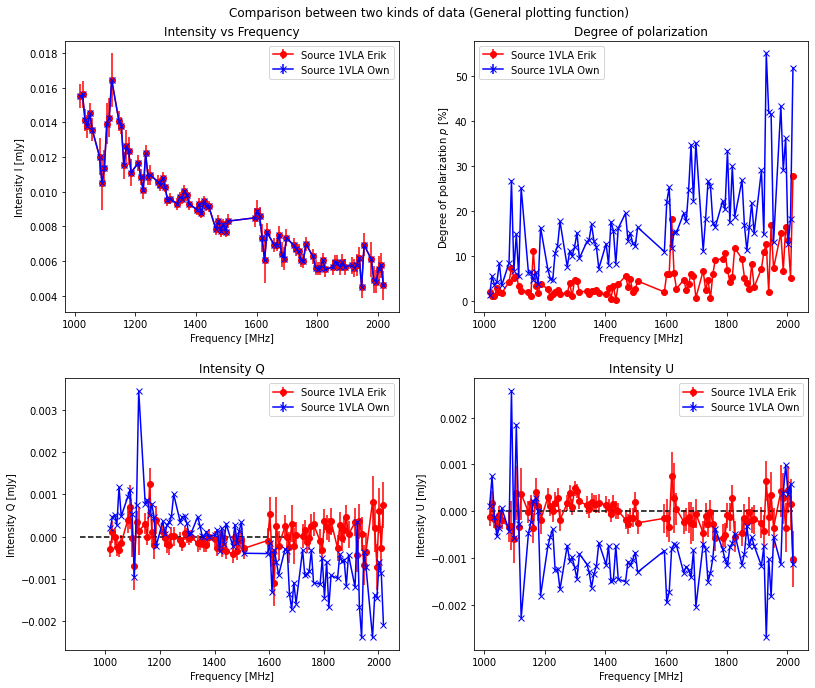

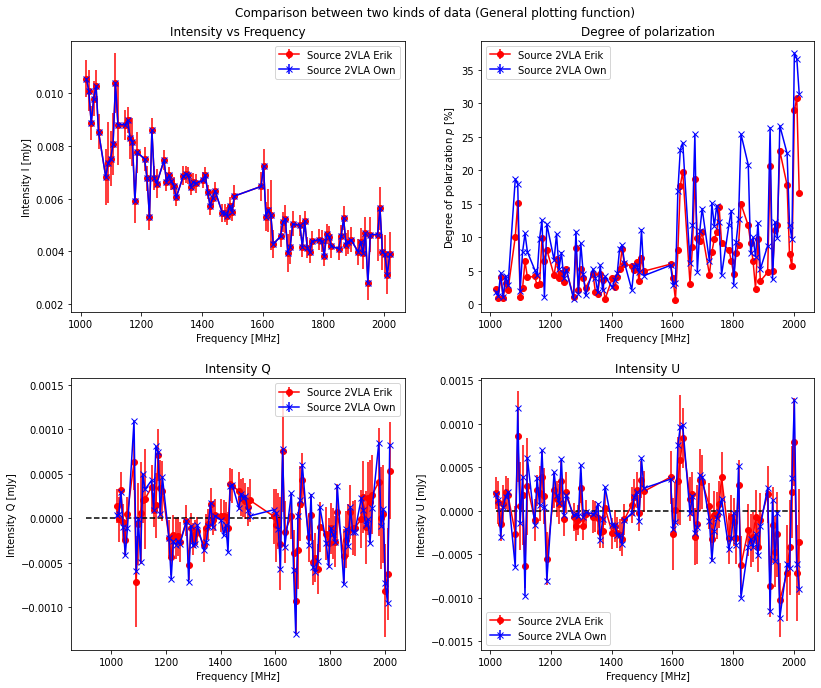

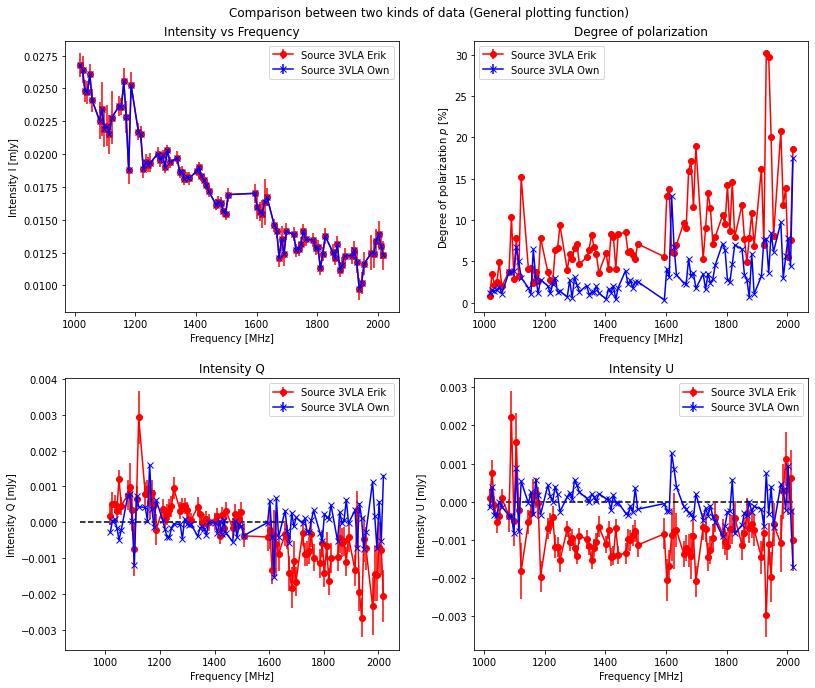

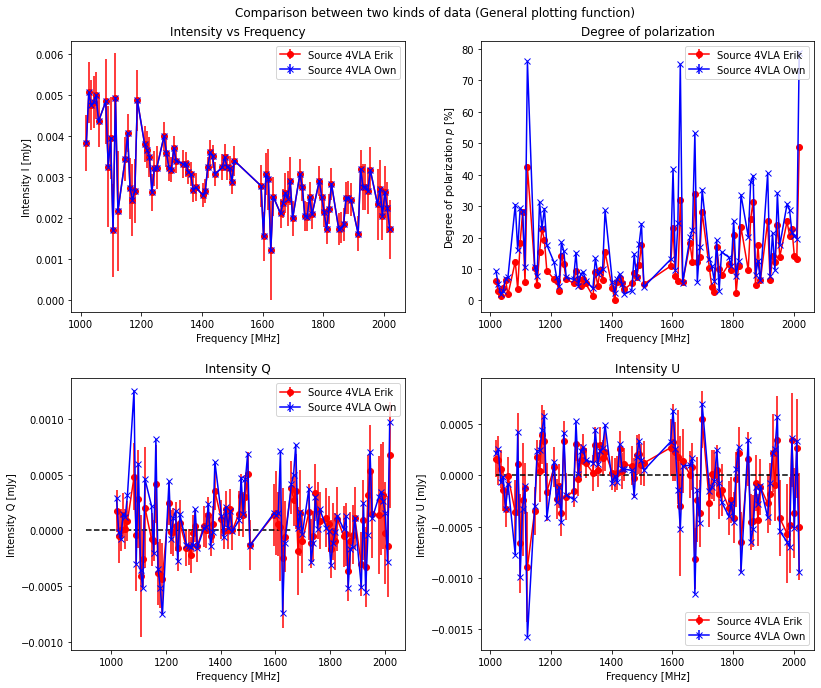

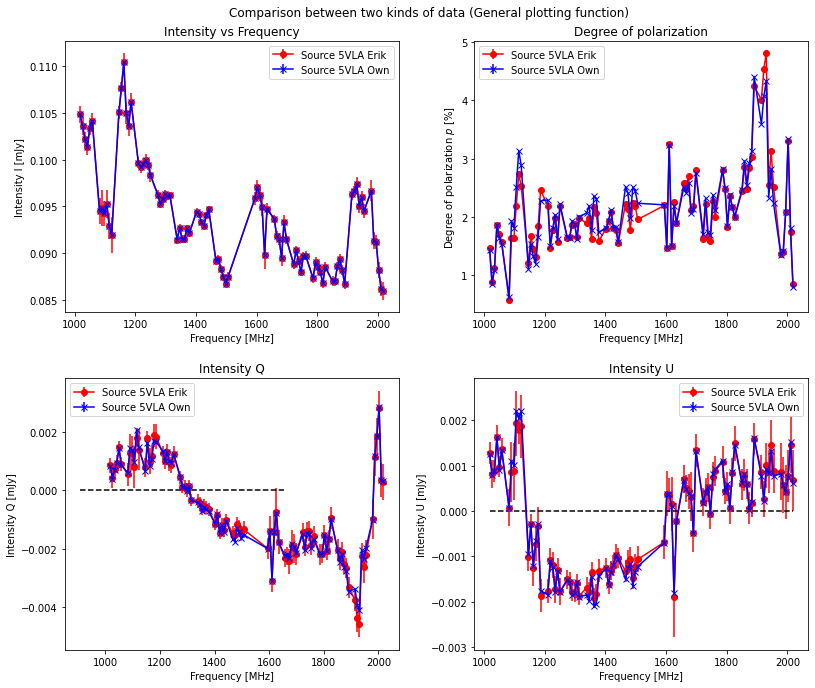

In [40]:
# Comparing our own unbinned VLA flux with Eriks unbinned VLA fluxes:
plotter(Freqs_VLA, Freqs_VLA, I_phot_table_VLA, I_phot_table_VLA, I_phot_table_VLA_err, np.zeros(np.shape(I_phot_table_VLA)), Q_phot_table_VLA, Q_phot_table_VLA_own, Q_phot_table_VLA_err, np.zeros(np.shape(U_phot_table_VLA_own)), U_phot_table_VLA, U_phot_table_VLA_own, U_phot_table_VLA_err, np.zeros(np.shape(U_phot_table_VLA_own)), Linpol_VLA, np.zeros(np.shape(Linpol_VLA)), Linpol_VLA_own, np.zeros(np.shape(Linpol_VLA_own)), Pol_Angles_VLA, Pol_Angles_VLA_own, Labels, name_1='VLA Erik', name_2='VLA Own', channels=True, polar=False, angle=False, statistic=False)

# Comparing eriks unbinned VLA fluxes with eriks binned VLA fluxes:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_hist_VLA, I_phot_table_VLA_err, I_hist_VLA_err, Q_phot_table_VLA, Q_hist_VLA, Q_phot_table_VLA_err, Q_hist_VLA_err, U_phot_table_VLA, U_hist_VLA, U_phot_table_VLA_err, U_hist_VLA_err, Linpol_VLA, np.zeros(np.shape(Linpol_VLA)), Linpol_VLA_hist, np.zeros(np.shape(Linpol_VLA_hist)), Pol_Angles_VLA, Pol_Angles_VLA_hist, Labels, name_1='VLA Erik', name_2='VLA Erik Binned', channels=False, polar=False, angle=False, statistic=False)

# Comparing own unbinned VLA fluxes with own binned VLA fluxes:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_hist_VLA, I_phot_table_VLA_err, I_hist_VLA_err, Q_phot_table_VLA_own, Q_hist_VLA_own, np.zeros(np.shape(Q_phot_table_VLA_own)), Q_hist_VLA_err_own, U_phot_table_VLA_own, U_hist_VLA_own, np.zeros(np.shape(U_phot_table_VLA_own)), U_hist_VLA_err_own, Linpol_VLA_own, np.zeros(np.shape(Linpol_VLA_own)), Linpol_VLA_hist_own, np.zeros(np.shape(Linpol_VLA_hist_own)), Pol_Angles_VLA_own, Pol_Angles_VLA_hist_own, Labels, name_1='VLA own unbinned', name_2='VLA own Binned', channels=False, polar=False, angle=False, statistic=False)

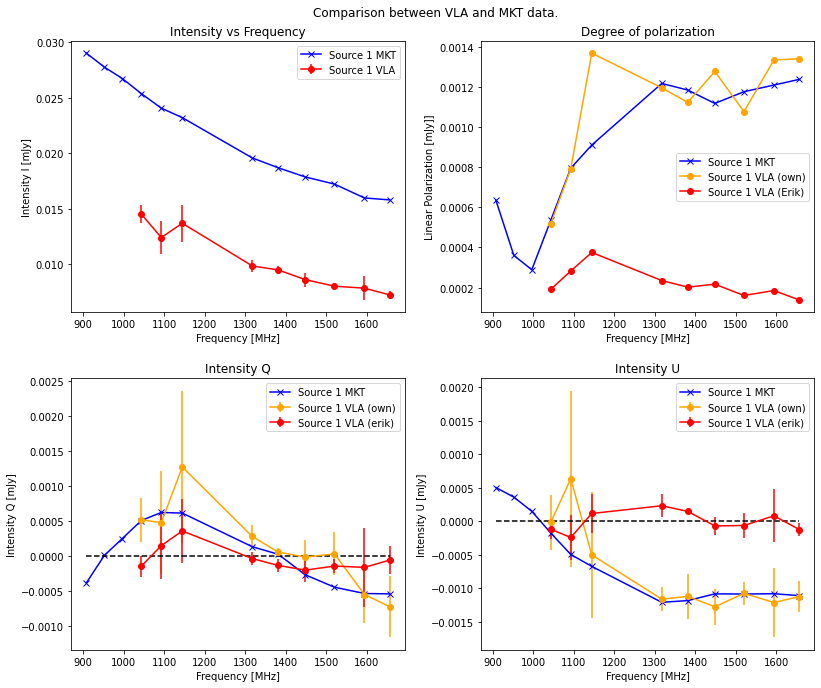

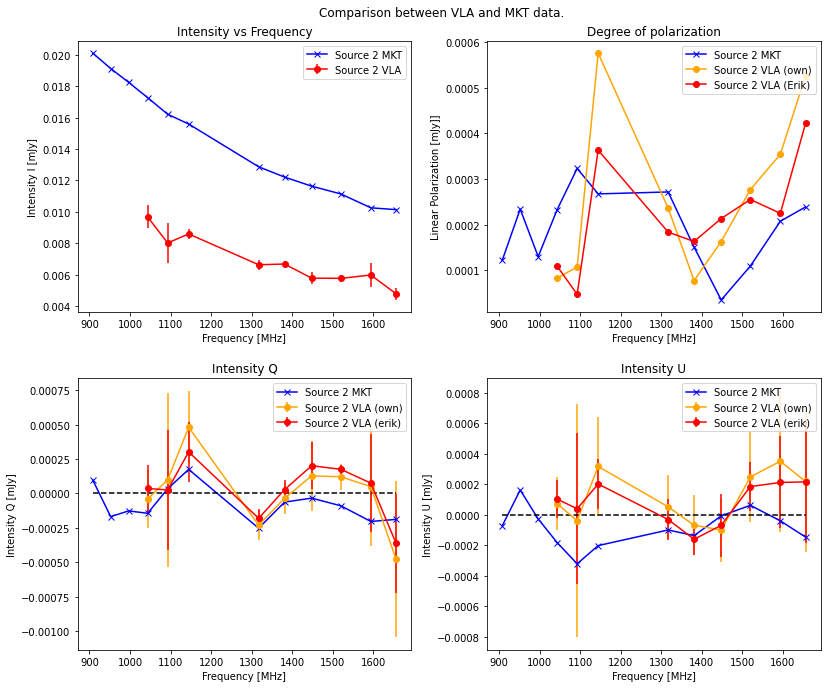

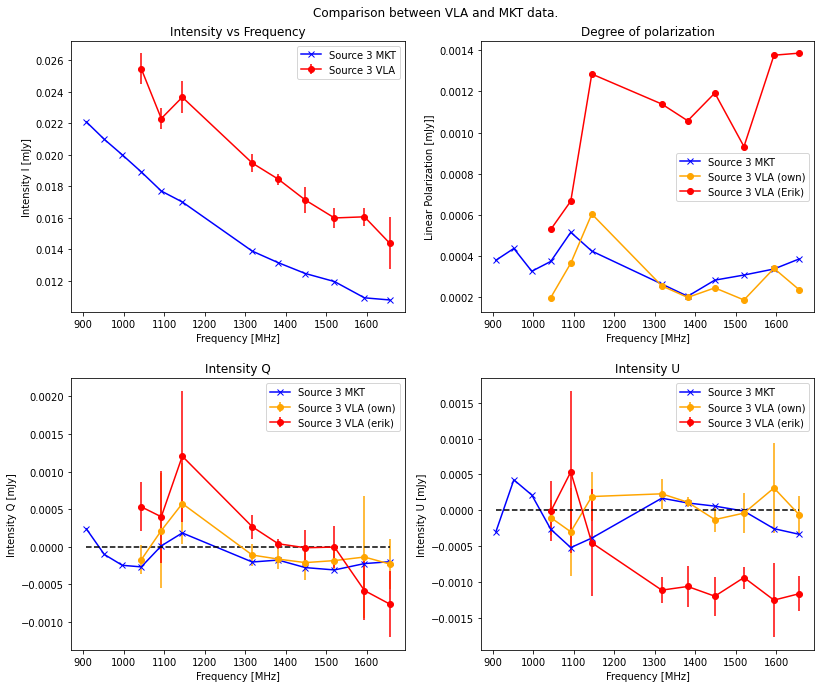

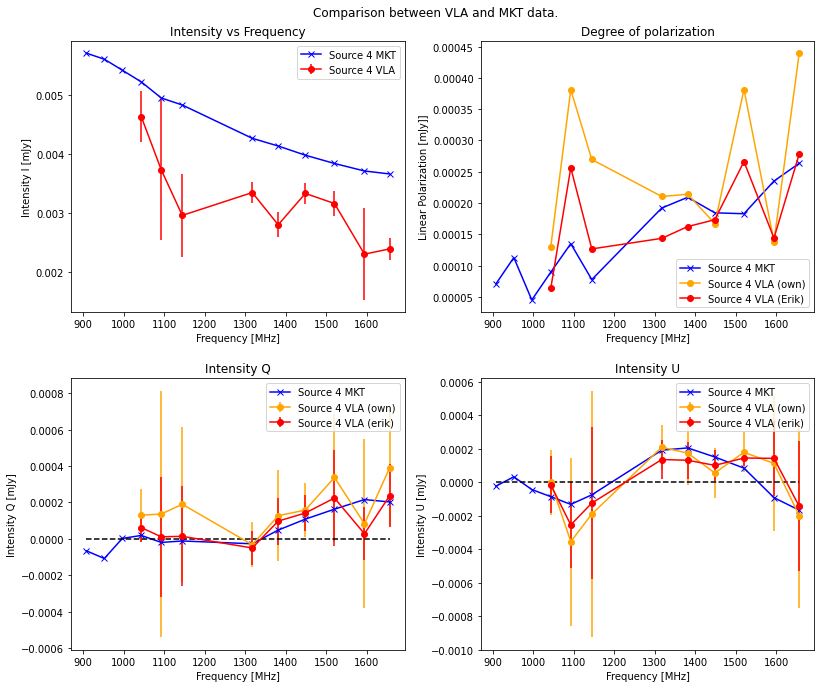

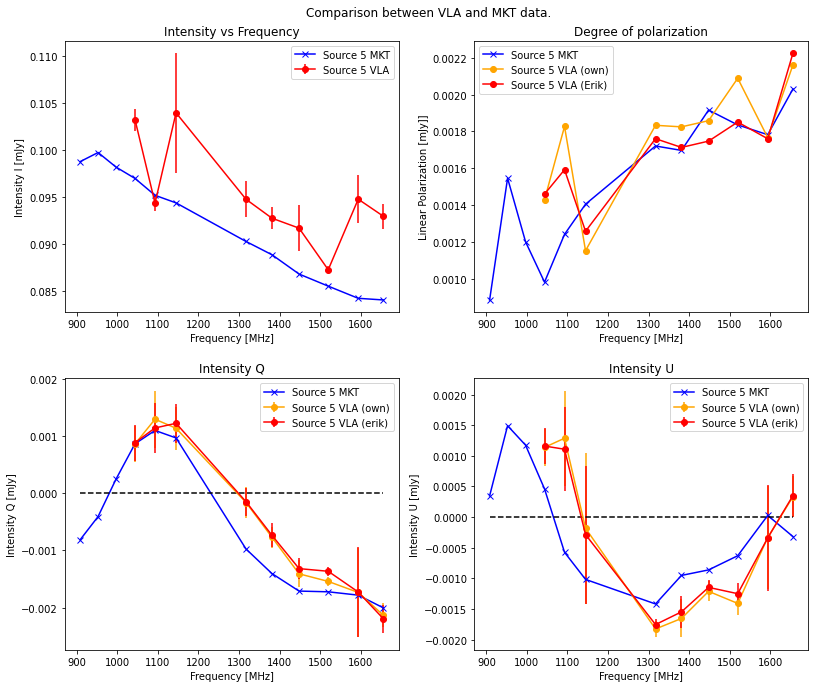

In [42]:
# To compare all three, MKT, Erik VLA flux and own VLA flux, we can't rely on plotting function

channels = True
polar = False
angle = False
statistic = False


if channels:
    for n in range(5):
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches(12, 10)
        fig.tight_layout(pad=4.5)

        fig.suptitle('Comparison between VLA and MKT data.')
        axs[0,0].errorbar(freqs_middle/1e6, I_hist_VLA[:,n], yerr=I_hist_VLA_err[:,n], label=Labels[n] + ' VLA', color='red', marker='o')
        axs[0,0].plot(freqs_middle/1e6, I_phot_table_compar[:,n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[0,0].set_title('Intensity vs Frequency')
        axs[0,0].set_xlabel('Frequency [MHz]')
        axs[0,0].set_ylabel('Intensity I [mJy]')
        axs[0,0].legend()

        axs[0,1].errorbar(freqs_middle/1e6, Linpol_VLA_hist_own[:,n], yerr=None, label=Labels[n] + ' VLA (own)', color='orange', marker='o')
        axs[0,1].errorbar(freqs_middle/1e6, Linpol_VLA_hist[:,n], yerr=None, label=Labels[n] + ' VLA (Erik)', color='red', marker='o')
        axs[0,1].plot(freqs_middle/1e6, Linpol_compar[:,n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[0,1].set_title('Degree of polarization')
        axs[0,1].set_xlabel('Frequency [MHz]')
        axs[0,1].set_ylabel('Linear Polarization [mJy]]')
        axs[0,1].legend()

        axs[1,0].errorbar(freqs_middle/1e6, Q_hist_VLA_own[:,n], yerr=Q_hist_VLA_err_own[:,n], label=Labels[n] + ' VLA (own)', color='orange', marker='o')
        axs[1,0].errorbar(freqs_middle/1e6, Q_hist_VLA[:,n], yerr=Q_hist_VLA_err[:,n], label=Labels[n] + ' VLA (erik)', color='red', marker='o')
        axs[1,0].plot(freqs_middle/1e6, Q_phot_table_compar[:,n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[1,0].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
        axs[1,0].set_title('Intensity Q')
        axs[1,0].set_xlabel('Frequency [MHz]')
        axs[1,0].set_ylabel('Intensity Q [mJy]')
        axs[1,0].legend()

        axs[1,1].errorbar(freqs_middle/1e6, U_hist_VLA_own[:,n], yerr=U_hist_VLA_err_own[:,n], label=Labels[n] + ' VLA (own)', color='orange', marker='o')
        axs[1,1].errorbar(freqs_middle/1e6, U_hist_VLA[:,n], yerr=U_hist_VLA_err[:,n], label=Labels[n] + ' VLA (erik)', color='red', marker='o')
        axs[1,1].plot(freqs_middle/1e6, U_phot_table_compar[:,n], label=Labels[n] + ' MKT', color='blue', marker='x')
        axs[1,1].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
        axs[1,1].set_title('Intensity U')
        axs[1,1].set_xlabel('Frequency [MHz]')
        axs[1,1].set_ylabel('Intensity U [mJy]')
        axs[1,1].legend()

        fig.savefig('VLA_MKT_Compar_Source'+str(n)+'.pdf')
        plt.show()

if polar:
    for n in range(len(sources_compar)):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        fig.set_size_inches(8, 8)
        ax.plot(4*Pol_Angles_compar[:,n], Linpol_compar[:,n],color='blue', marker='x')
        ax.plot(4*Pol_Angles_VLA_hist_own[:,n], Linpol_VLA_hist_own[:,n],color='red', marker='o')
        ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
        ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
        ax.grid(True)
        ax.set_title(r" Source "+str(n+1)+r": $\chi$ [degrees] vs Linpol [mJy]")
        plt.show()

if angle:
    for n in range(len(sources_compar)):
        plt.figure(figsize=(8,6))
        plt.plot(freqs_middle/1e6, Pol_Angles_compar[:,n], color='blue', marker='x')
        plt.plot(freqs_middle/1e6, Pol_Angles_VLA_hist_own[:,n], color='red', marker='o')
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Angle [Deg]')
        plt.title(r" Source "+str(n+1)+r' Angle vs frequency VLA and MKT comparison (red=VLA, blue=MKT)')
        plt.show()

if statistic:
    colors=['red','orange','green','blue','purple']
    for n in range(5):
        plt.scatter(Q_phot_table_compar[:,n], Q_hist_VLA_own[:,n], color=colors[n])
    plt.title('Correlation Q intensity')
    plt.xlabel('Meerkat Q [mJy]')
    plt.ylabel('VLA Q [mJy]')
    plt.show()
    for n in range(5):
        plt.scatter(U_phot_table_compar[:,n], Q_hist_VLA_own[:,n], color=colors[n])
    plt.title('Correlation U intensity')
    plt.xlabel('Meerkat U [mJy]')
    plt.ylabel('VLA U [mJy]')
    plt.show()